# CS 585 HW 1

**Due:** 11:59 PM (at midnight) EST, Wednesday, February 14, 2024

**Completed By:**
* Muhammad Aseef Imran
* Munir Siddiqui

In [14]:
# imports
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import math
from typing import Any
from numpy import ndarray, dtype, generic
from cv2 import Mat, UMat
from cv2 import VideoCapture

In [15]:
webcam = cv.VideoCapture(0)

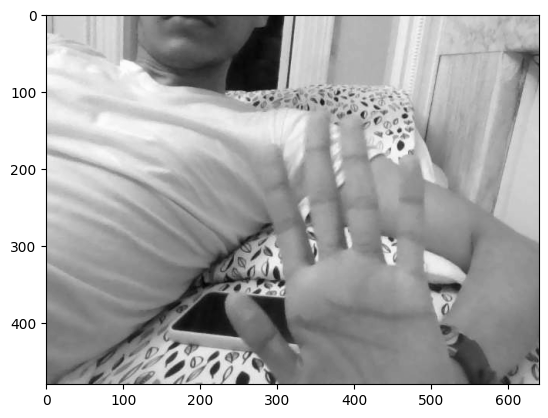

In [16]:
success, frame = webcam.read()
if success:
    grayscale = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    plt.imshow(grayscale, cmap='gray')
    plt.plot()

In [17]:
from cv2.gapi.wip.draw import Image

def plt_show_img(name: str, img: Image):
    # plt.imshow(img)
    # plt.plot()
    cv.namedWindow(name, cv.WINDOW_AUTOSIZE)
    cv.imshow(name, img)
    #cv.waitKey(0)

In [18]:
def rescaleFrame(frame: Mat | ndarray[Any, dtype[generic]] | ndarray, scale) -> UMat:
    height = int(frame.shape[0] * scale)
    width = int(frame.shape[1] * scale)
    return cv.resize(frame, (width, height), interpolation=cv.INTER_AREA)

In [19]:
def setResLiveVideo(frame: VideoCapture, width: int):
    # given the width we automatically figure out the height
    scale = width / frame.get(3)
    height = int(frame.get(4) * scale)
    webcam.set(3, width)
    webcam.set(4, height)

In [20]:
# rescale frame for faster computation
setResLiveVideo(webcam, 400)

In [21]:
def calc_area(img: np.ndarray):
    return np.count_nonzero(img)

In [22]:
def find_centroid(img: np.ndarray):
    area = calc_area(img)
    # calculate the first moment
    # m10 = 0
    # m01 = 0
    # for i in range(img.shape[0]):
    #     for j in range(img.shape[1]):
    #         if img[i, j] > 0:
    #             m10 += i
    #             m01 += j
    # above code works, but numpy is faster!
    m10 = np.sum(np.where(img > 0)[0])
    m01 = np.sum(np.where(img > 0)[1])

    # calculate the centroid
    x = m10 / area
    y = m01 / area
    return (x, y)

In [23]:
def find_axis_of_least_inertia(img: np.ndarray):
    # calc first moments
    x, y = find_centroid(img)
    # calculate the second moments
    # m11 = 0
    # m20 = 0
    # m02 = 0
    # for i in range(img.shape[0]):
    #     for j in range(img.shape[1]):
    #         if img[i, j] > 0:
    #             m11 += (i - x) * (j - y)
    #             m20 += (i - x) ** 2
    #             m02 += (j - y) ** 2

    # does the same thing as above but numpy is faster so..
    m11 = np.sum((np.where(img > 0)[0] - x) * (np.where(img > 0)[1] - y))
    m20 = np.sum((np.where(img > 0)[0] - x) ** 2)
    m02 = np.sum((np.where(img > 0)[1] - y) ** 2)

    # calculate the angle of least inertia
    theta = 0.5 * np.arctan2(2 * m11, m20 - m02)
    # draw the angle line with midpoint at centroid
    x1 = int(x + 100 * np.cos(theta))
    y1 = int(y + 100 * np.sin(theta))
    x2 = int(x - 100 * np.cos(theta))
    y2 = int(y - 100 * np.sin(theta))

    img = cv.cvtColor(img, cv.COLOR_GRAY2RGB)
    img = cv.line(img, (y1, x1), (y2, x2), (0, 255, 0), 2)
    cv.putText(img, f'{theta}', (10, 30), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv.LINE_AA)
    plt_show_img("Angle of Least Inertia", img)

    print(f'Angle of least inertia: {theta} {math.degrees(theta)}')
    return (x, y), (theta)

In [24]:
# def count_fingers(thresh_output: np.ndarray, hand_contour: np.ndarray) -> int:
#     # Find convex hull of hand contour
#     hull = cv.convexHull(hand_contour, returnPoints=False)

#     # Find convexity defects
#     defects = cv.convexityDefects(hand_contour, hull)

#     # Count fingers
#     finger_count = 0
#     if defects is not None:
#         for i in range(defects.shape[0]):
#             start, end, far, _ = defects[i, 0]
#             start_point = tuple(hand_contour[start][0])
#             end_point = tuple(hand_contour[end][0])
#             far_point = tuple(hand_contour[far][0])

#             # Calculate triangle edges lengths
#             a = np.linalg.norm(np.array(far_point) - np.array(end_point))
#             b = np.linalg.norm(np.array(far_point) - np.array(start_point))
#             c = np.linalg.norm(np.array(start_point) - np.array(end_point))

#             # Apply cosine rule to find angle
#             angle = np.arccos((a**2 + b**2 - c**2) / (2 * a * b))

#             # Check if angle is acute and far enough from the hand
#             if angle <= np.pi / 2 and np.linalg.norm(np.array(far_point) - np.array(start_point)) > 30:
#                 finger_count += 1

#     return finger_count

In [25]:
def identify_finger_tips(contours):
    finger_tips = []
    for contour in contours:
        # Find convex hull
        hull = cv.convexHull(contour, returnPoints=False)
        
        # Find convexity defects
        defects = cv.convexityDefects(contour, hull)
        
        if defects is not None:
            for i in range(defects.shape[0]):
                s, e, f, _ = defects[i, 0]
                start = tuple(contour[s][0])
                end = tuple(contour[e][0])
                far = tuple(contour[f][0])
                
                # Check if the far point is above the midpoint between start and end
                # This helps in filtering out inner hand contours
                dist_start_end = np.linalg.norm(np.array(end) - np.array(start))
                dist_start_far = np.linalg.norm(np.array(far) - np.array(start))
                dist_end_far = np.linalg.norm(np.array(far) - np.array(end))
                angle = math.degrees(math.acos((dist_start_far**2 + dist_end_far**2 - dist_start_end**2) / (2 * dist_start_far * dist_end_far)))
                if angle < 90:
                    finger_tips.append(far)
    return finger_tips

In [26]:
while True:
    success, frame = webcam.read()
    if not success:
        print('Failed to capture frame')
        break

    frame_orig = frame.copy()
    
    plt_show_img("Original", frame_orig)

    # convert the video frame into a binary image
    # so that all pixels that look like skin color
    # are included in the binary object
    hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
    ycrcb = cv.cvtColor(frame, cv.COLOR_BGR2YCrCb)

    # Define the thresholds for HSV color space
    lower_hsv = np.array([0, 15, 0], dtype=np.uint8)
    upper_hsv = np.array([17, 170, 255], dtype=np.uint8)

    # Define the thresholds for YCrCb color space
    lower_ycrcb = np.array([0, 135, 85], dtype=np.uint8)
    upper_ycrcb = np.array([255, 180, 135], dtype=np.uint8)

    # Create masks for each color space
    mask_hsv = cv.inRange(hsv, lower_hsv, upper_hsv)
    mask_ycrcb = cv.inRange(ycrcb, lower_ycrcb, upper_ycrcb)

    # Combine the masks
    mask_combined = cv.bitwise_and(mask_hsv, mask_ycrcb)

    # Apply the combined mask to the original frame
    frame = cv.bitwise_and(frame, frame, mask=mask_combined)

    # Display the masked video
    plt_show_img("Masked", frame)

    # smooth out the image via median blur (take the median of surrounding pixels)
    # effective for removing the noise
    frame = cv.medianBlur(frame,13)

    #cv.imshow('Video 1', frame)

    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    _, thres_output = cv.threshold(gray, 20, 255, cv.THRESH_BINARY)

    # find largest object in the binary image
    contours, _ = cv.findContours(thres_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=lambda x: cv.contourArea(x), reverse=True)

    if len(contours) == 0:
        continue

    # draw the largest object
    if len(contours) > 0:
        x, y, w, h = cv.boundingRect(contours[0])
        thres_output = cv.rectangle(thres_output, (x, y), (x+w, y+h), (0, 255, 0), 4)

    # get rid of everything except the largest object
    mask = np.zeros(thres_output.shape, dtype=np.uint8)
    cv.drawContours(mask, contours, 0, (255, 255, 255), -1)
    thres_output = cv.bitwise_and(thres_output, mask)
    # fill holes in the contour
    cv.fillPoly(thres_output, pts =[contours[0]], color=(255,255,255))

    centroid, theta = find_axis_of_least_inertia(thres_output)

    # rotate such that the line of least inertia is horizontally flat
    (rows, cols) = thres_output.shape
    M = cv.getRotationMatrix2D((centroid[0], centroid[1]), -math.degrees(theta), 1)
    img = cv.warpAffine(thres_output, M, (cols, rows))
    plt_show_img("Post rotation", img)

    # Identify finger tips
    finger_tips = identify_finger_tips(contours)

    # Draw finger tips
    for tip in finger_tips:
        cv.circle(frame, tip, 5, (0, 0, 255), -1)

    # Show frame
    cv.imshow("Finger Tips", frame)


    # hand_region = img[y:y+h, x:x+w]

    # # Threshold hand region
    # _, hand_thresh = cv.threshold(hand_region, 20, 255, cv.THRESH_BINARY)

    # # Find contours in the hand region
    # hand_contours, _ = cv.findContours(hand_thresh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # # Filter out small contours (noise)
    # hand_contours = [cnt for cnt in hand_contours if cv.contourArea(cnt) > 100]

    # # Assuming the largest contour corresponds to the hand
    # if len(hand_contours) > 0:
    #     hand_contour = max(hand_contours, key=cv.contourArea)
    #     # Count fingers
    #     finger_count = count_fingers(hand_thresh, hand_contour)
    #     print("Number of fingers raised:", finger_count)

    #     # Overlay finger count on original frame
    #     cv.putText(frame_orig, f"Fingers Raised: {finger_count}", (50, 50), cv.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv.LINE_AA)

    # # Display the original frame with finger count
    # plt_show_img("Original with Finger Count", frame_orig)

    if cv.waitKey(20) & 0xFF==ord('d'):
        break

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\convhull.cpp:360: error: (-5:Bad argument) The convex hull indices are not monotonous, which can be in the case when the input contour contains self-intersections in function 'cv::convexityDefects'


Angle of least inertia: -1.3164344228159177 -75.42613643309261


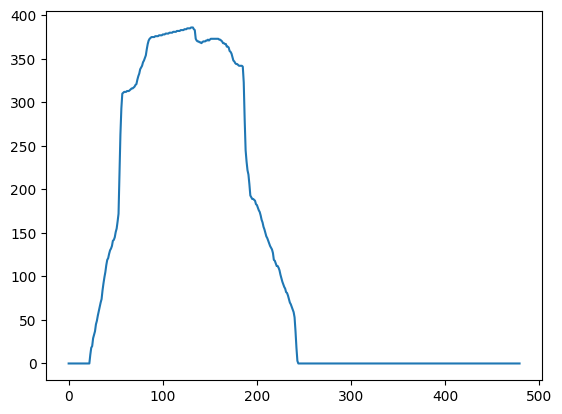

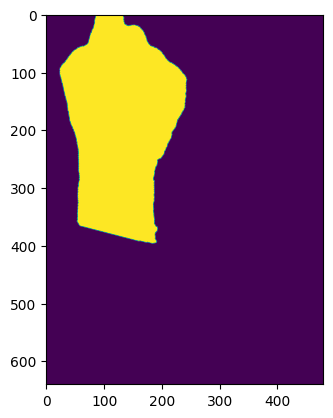

Angle of least inertia: -1.2814991814478625 -73.4244945464322


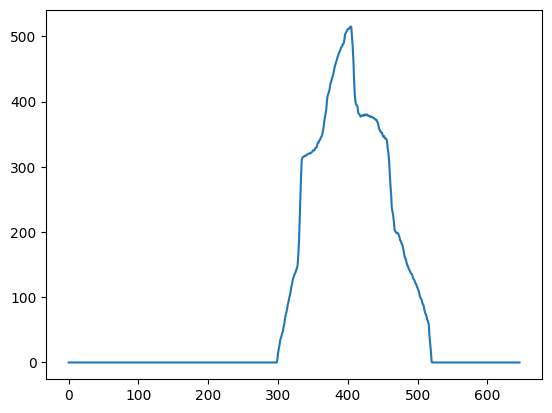

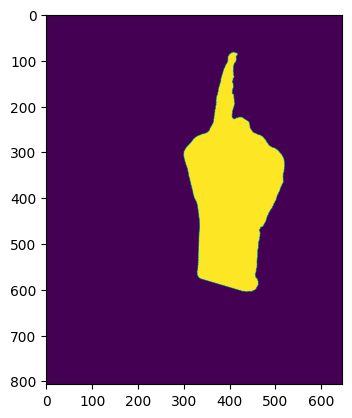

Angle of least inertia: -1.3520550901406632 -77.46705033424008


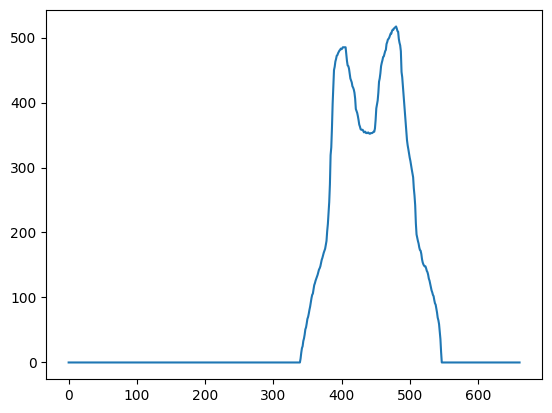

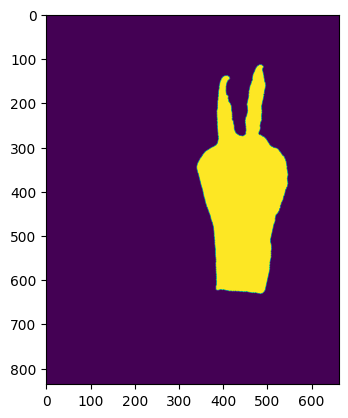

Angle of least inertia: -1.4140726502974736 -81.02039478692402


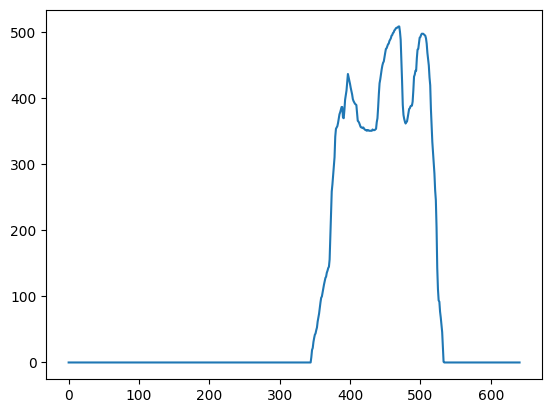

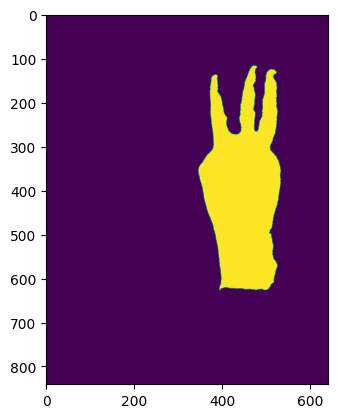

Angle of least inertia: -1.4870696585722207 -85.20281527814856


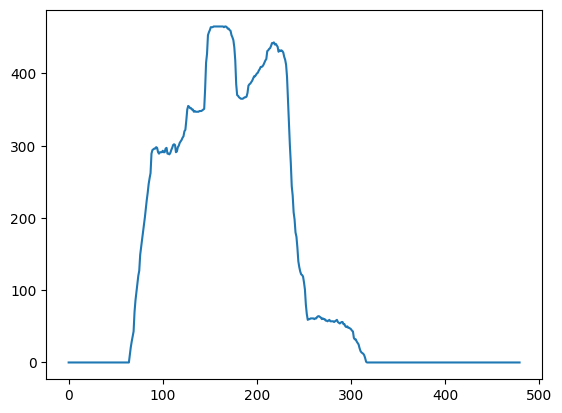

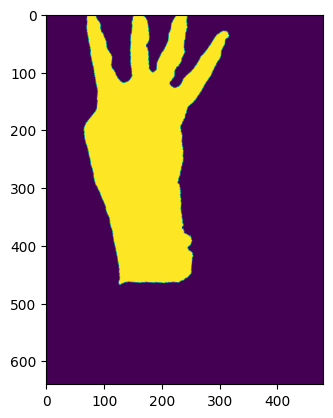

Angle of least inertia: -1.5239529644019505 -87.31607303668235


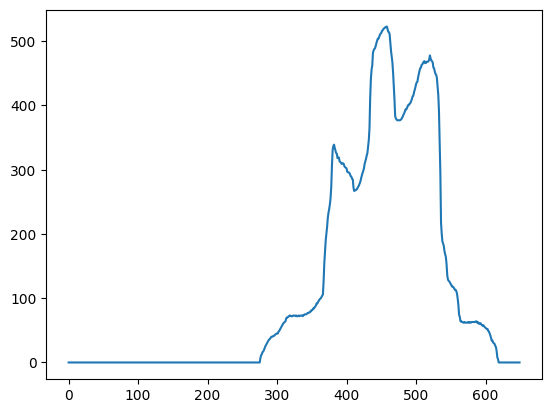

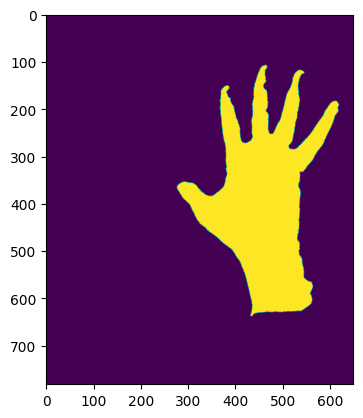

In [ ]:
# for i in range(0, 6):
#     frame = cv.imread(f"{i}-fingers.png")
#
#     plt_show_img("Original", frame)
#
#     # convert the video frame into a binary image
#     # so that all pixels that look like skin color
#     # are included in the binary object
#     hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
#     ycrcb = cv.cvtColor(frame, cv.COLOR_BGR2YCrCb)
#
#     # Define the thresholds for HSV color space
#     lower_hsv = np.array([0, 15, 0], dtype=np.uint8)
#     upper_hsv = np.array([17, 170, 255], dtype=np.uint8)
#
#     # Define the thresholds for YCrCb color space
#     lower_ycrcb = np.array([0, 135, 85], dtype=np.uint8)
#     upper_ycrcb = np.array([255, 180, 135], dtype=np.uint8)
#
#     # Create masks for each color space
#     mask_hsv = cv.inRange(hsv, lower_hsv, upper_hsv)
#     mask_ycrcb = cv.inRange(ycrcb, lower_ycrcb, upper_ycrcb)
#
#     # Combine the masks
#     mask_combined = cv.bitwise_and(mask_hsv, mask_ycrcb)
#
#     # Apply the combined mask to the original frame
#     frame = cv.bitwise_and(frame, frame, mask=mask_combined)
#
#     # Display the masked video
#     plt_show_img("Masked", frame)
#
#     # smooth out the image via median blur (take the median of surrounding pixels)
#     # effective for removing the noise
#     frame = cv.medianBlur(frame,13)
#
#     #cv.imshow('Video 1', frame)
#
#     gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
#     _, thres_output = cv.threshold(gray, 20, 255, cv.THRESH_BINARY)
#
#     # find largest object in the binary image
#     contours, _ = cv.findContours(thres_output, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
#     contours = sorted(contours, key=lambda x: cv.contourArea(x), reverse=True)
#
#
#     # draw the largest object
#     if len(contours) > 0:
#         x, y, w, h = cv.boundingRect(contours[0])
#         thres_output = cv.rectangle(thres_output, (x, y), (x+w, y+h), (0, 255, 0), 4)
#
#     # get rid of everything except the largest object
#     mask = np.zeros(thres_output.shape, dtype=np.uint8)
#     cv.drawContours(mask, contours, 0, (255, 255, 255), -1)
#     thres_output = cv.bitwise_and(thres_output, mask)
#     # fill holes in the contour
#     cv.fillPoly(thres_output, pts =[contours[0]], color=(255,255,255))
#
#     centroid, theta = find_axis_of_least_inertia(thres_output)
#
#     # rotate such that the line of least inertia is horizontally flat
#     (rows, cols) = thres_output.shape
#     M = cv.getRotationMatrix2D((centroid[0], centroid[1]), -math.degrees(theta), 1)
#     img = cv.warpAffine(thres_output, M, (rows, cols))
#     plt_show_img("Post rotation", img)
#
#     # make a histogram of the x positions of the binary image and plot it
#
#     # first use np to make the bins
#     bins = np.arange(0, img.shape[1], 1)
#     # then use np to make the histogram
#     hist = np.histogram(np.where(img > 0)[1], bins=range(img.shape[1] + 1))
#     # then plot the histogram
#     plt.figure()
#     plt.plot(hist[0])
#     plt.show()
#
#     plt.imshow(img)
#     plt.show()
